# <center>Fuzzy Clustering</center>
## <center>Inclass Project 1 - MA4144</center>

This project contains 9 tasks/questions to be completed, some require written answers. Open markdow cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle**.

Use this cell to use any include any imports

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

**Q1.** In the following cell load the data (in the file SMDataRefined.csv) to a pandas dataframe, and display the data. Then get the data into a numpy matrix $X$, each row corresponding to a datapoint and each column to a feature, in our case whether a certain token exists ($1$) or not ($0$). Let us denote the number of rows of $X$ by $N$ and the number of columns by $M$.

**About the dataset**: Each row in the dataset refers to a social media post. The first column refers to the number of likes received by each post (standardized between to the interval $[0, 1]$), the columns after that will denote the presence of a certain word (token) in the text of the post. For example, a $1$ in the column "TextToken_life" denotes that the particular post contained the word "life" in it and $0$ otherwise. These will be the features of our dataset. Our aim is to cluster these social media posts based on number of likes and words contained in it.

In [33]:
#Load data
dataframe = pd.read_csv('SMDataRefined.csv')
#print(dataframe)

# Get the data into a numpy matrix
matrix_X = dataframe.to_numpy()
print(matrix_X)
# N denotes the number of rows a and M denotes the number of columns 
N,M = matrix_X.shape
print(N,M)

[[0.28571429 0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.42857143 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.45714286 0.         1.         ... 0.         0.         0.        ]
 [0.47142857 0.         0.         ... 0.         0.         0.        ]
 [0.52857143 0.         0.         ... 0.         0.         0.        ]]
732 11


**Q2.** In the following cell create a new function named $\textrm{initMu}$, that takes in two parameters $\textrm{npoints}$ and $\textrm{nclusters}$ and outputs the membership matrix for $\textrm{npoints}$ number of data points and $\textrm{nclusters}$ number of clusters. Recall from the lecture that the membership matrix $U$ of dimension $N \times c$ has the following properties.

1. $0 \leq u_{ij} \leq 1$
2. $\sum\limits_{j = 1}^{c}u_{ij} = 1$ for all $i = 1,2, \cdots, N$

You can do a random initialization. Here $\textrm{npoints} = N$ and $\textrm{nclusters} = c$.

In [34]:
def initMu(npoints, nclusters):
    while True:
        mu_zero = np.random.rand(npoints, nclusters)
        
        mu_row_sum = mu_zero.sum(axis=1, keepdims=True)
        # print(mu_row_sum)
        # Divide each row by its row sum so that the sum of each row is 1
        mu_zero = mu_zero / mu_row_sum

        #chack if 0 < column sum < npoints
        column_sums = mu_zero.sum(axis=0)
        if np.all(column_sums > 0) and np.all(column_sums < npoints):
            break
    return mu_zero


**Q3.** In the following cell create a function named $\textrm{calculateCenters}$ that computes and returns centers $v_j$, $j = 1, 2, \cdots, c$ (as $c \times M$ matrix) given the data matrix $X$ and the membership matrix $U$. Recall the following update formula for $v_j$ from the lectures.

$v_j = \frac{\sum\limits_{i = 1}^N {\left( \frac{u_{ij}}{u_{max}} \right)}^{m_1} x_i}{\sum\limits_{i = 1}^N {\left( \frac{u_{ij}}{u_{max}} \right)}^{m_1}}$

Here $u_{max} = max \left(u_{1j}, u_{2j}, \cdots, u_{Nj} \right)$ and $m_1 \in [1, \infty)$ is a hyperparameter we discussed in class, and will be passed in as a parameter to the function.

The most efficient way to do this computation is by matrix multiplications. Try to find the appropriate matrix multiplication. You may need to transpose certain matrices.

In [35]:
def calculateCenters(X, U, m):
    U_m_transpose = (U ** m).T
    
    # print(U_m_transpose)
    
    numerator = U_m_transpose @ X 
    # Get the sum of membership functions(mu) for each cluster
    denominator = U_m_transpose.sum(axis=1, keepdims=True)
    V = numerator/denominator
    
    return V

X = np.array([[1, 2, 5], [3, 4, 6], [5, 6,8]])
U = np.array([[2, 8], [5, 5], [9, 3]])
m = 3

V = calculateCenters(X, U, m)
print("Cluster Centers:\n", V)

Cluster Centers:
 [[4.67285383 5.67285383 7.68213457]
 [1.53915663 2.53915663 5.31024096]]


**Q4.** In the following cell create a function named $\textrm{updateMu}$ that updates the membership matrix $U$ given the data matrix $X$ and the $\textrm{centers}$. Recall the following update formula for $u_{ij}$ from the lectures.

$u_{ij} = {\left[ \sum\limits_{l = 1}^c { \left( \frac{d_{ij}}{d_{il}} \right)}^{\frac{2}{m_2 - 1}} \right]}^{-1}$
where $d_{ij}$ is the distance between the $i$th data point and the $j$th cluster center. $m_2 \in (1, \infty)$ is another hyperparameter that is passed into the function.

To compute distances sklearn.metrics.pairwise.pairwise_distances could be useful. For these computations, try to avoid for loops as much as possible and use the tools offered by numpy for matrix manipulations for example such as numpy.tile.

The function should finally return the updated $U$ matrix.

In [36]:
def updateMu(X, centers, m):
    # get the number of centers (clusters)
    num_of_centers = centers.shape[0]
    #print(num_of_centers)
    exponent = 2 / (m - 1)
    
    # Get distances  between the i th data point and the j th cluster center
    d_ij = pairwise_distances(X, centers, metric='euclidean')
    d_ij[d_ij == 0] = 0.0000001
    
    
    d_ij_numerator = np.tile(d_ij[:, :, np.newaxis], (1, 1, num_of_centers))

    d_ij_denominator = np.tile(d_ij[:, np.newaxis, :], (1, num_of_centers,  1))

    # print(d_ij_numerator,d_ij_numerator.shape)
    # print()
    # print(d_ij_denominator,d_ij_denominator.shape)
    # print()
    with np.errstate(divide='ignore', invalid='ignore'):
        ratios =  (d_ij_numerator /d_ij_denominator) ** exponent
        ratio_sum =  np.sum(ratios, axis=2)
        U = 1/ratio_sum   
        
        
        # print(ratios)
        # print()
        # print(ratio_sum)
        
    return U
    
   
    
X = np.array([[1, 2], [2, 3], [3, 4],[5,2]])
C = np.array([[1, 3], [5, 3],[14,7]])
m = 3

U = updateMu(X, C, m)
print(U)

[[0.76084309 0.18453156 0.05462535]
 [0.7080196  0.23600653 0.05597386]
 [0.45534933 0.45534933 0.08930135]
 [0.1810421  0.74645571 0.07250219]]


**Q5.** Use following cell to create a function called $\textrm{fuzzyClustering}$ that takes in a data matrix $X$ the number of clusters $\textrm{nclusters}$, $m_1$, $m_2$ hyperparameters and then returns a membership matrix $U$ and nclusters number of centers for each cluster as a matrix whose rows will correspond to the centers. Recall that the fuzzy clustering algorithm,

1. Initialize the membership matrix $U$
Repeat the following steps while max iterations (maxIter) reached or change in norm of $U$ is greater than a specified tolerance (tol).
2. Compute cluster centers
3. Update membership matrix

The function you create should be able to compute the norm between the $U$ matrices from consecutive iterations and plot a graph depicting the variation of the change in norm of $U$ against the number of iterations. 

In [67]:
def fuzzyClustering(X, m1, m2, nclusters, maxiter = 50, tol = 10**(-5), isPlot=False): #isPlot is used to check if plot is needed or not
    npoints = X.shape[0] #number of data points
    U = initMu(npoints, nclusters)
    norm_diffs = []
    for iteration in range(maxIter):
        V = calculateCenters(X, U, m1) #Compute cluster centers
        U_new = updateMu(X, V, m2)
        
        norm_diff = np.linalg.norm(U_new - U) # Get the difference between previous U and new U
        norm_diffs.append(norm_diff)
        if norm_diff < tol:
            break
        
        # Update U for the next iteration
        U = U_new
    if(isPlot):
        print("no of total iterations: ",len(norm_diffs))
        plt.plot(norm_diffs)
        plt.xlabel('Iteration')
        plt.ylabel('Change in Norm')
        plt.title('Change in Norm vs. Number of Iterations')
        plt.show()
        
    return U_new, V 
    
X = np.array([[1, 2], [2, 3], [3, 9], [5, 2]])
nclusters = 2
m1 = 2
m2 = 3
maxIter = 100
tol = 1e-3

U, V = fuzzyClustering(matrix_X , m1, m2, nclusters, maxIter, tol)
print("Membership Matrix U:")
print(U, U.shape,"\n")
print("Cluster Centers:")
print(V, V.shape)


Membership Matrix U:
[[0.50000343 0.49999657]
 [0.50007872 0.49992128]
 [0.50024776 0.49975224]
 ...
 [0.49999704 0.50000296]
 [0.50014887 0.49985113]
 [0.49997361 0.50002639]] (732, 2) 

Cluster Centers:
[[0.46995292 0.03004584 0.03141087 0.03141107 0.03141134 0.02867963
  0.0341427  0.01365721 0.03414334 0.03277691 0.05189575]
 [0.47009394 0.03006345 0.03143066 0.03143046 0.03143019 0.02869742
  0.03416331 0.0136652  0.03416267 0.03279686 0.05192938]] (2, 11)


**Q6.** Run the fuzzyClasssification algorithm with different hyperparameters $m_1, m_2, \textrm{nclusters}$, note the plot of $U$-norm difference against the number of iterations. <font color='blue'>What can you say about it?</font>

Now lets use the fuzzy membership to find some crisp cluster labelling $\textrm{yfuzzy}$ to for each data point. For a given datapoint you'll assign the cluster labelling by looking at which cluster assigns the largest membership value. numpy.argmax function would be useful in this case. Again avoid for loops. 

Running fuzzy_clustering with n_clusters=2 and m1=1.5  and m2=2.0
no of total iterations:  44


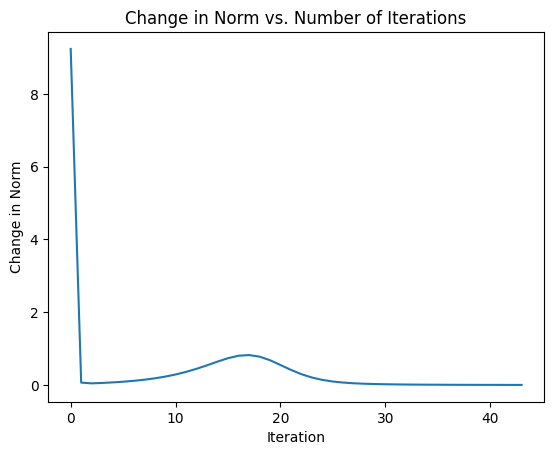

Running fuzzy_clustering with n_clusters=2 and m1=1.5  and m2=2.5
no of total iterations:  24


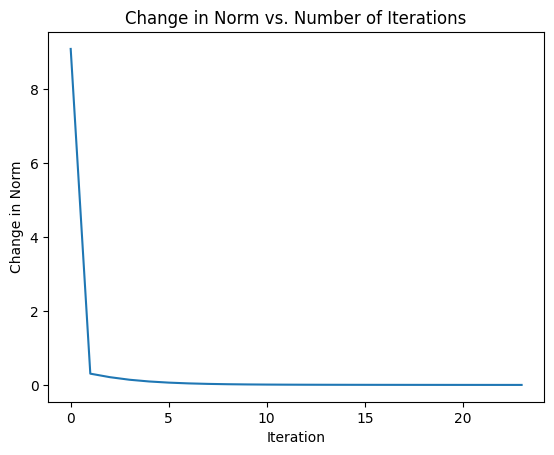

Running fuzzy_clustering with n_clusters=2 and m1=1.5  and m2=3.0
no of total iterations:  12


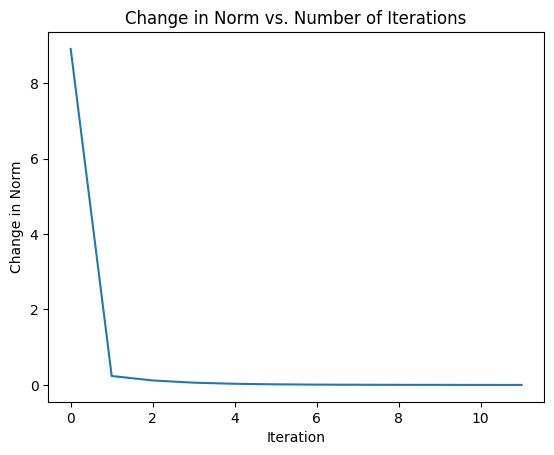

Running fuzzy_clustering with n_clusters=2 and m1=1.8  and m2=2.0
no of total iterations:  31


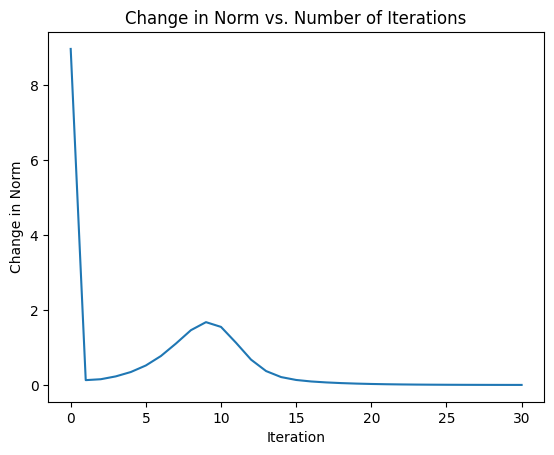

Running fuzzy_clustering with n_clusters=2 and m1=1.8  and m2=2.5
no of total iterations:  100


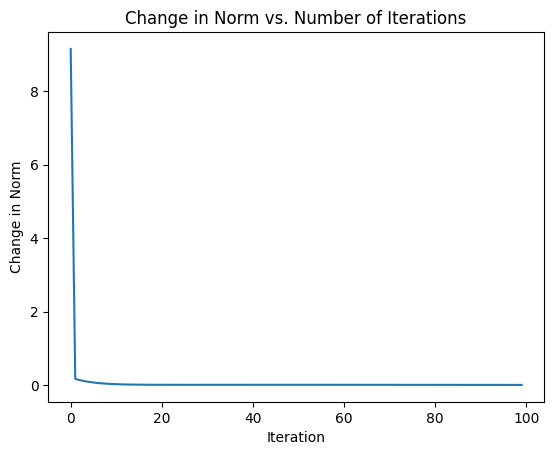

Running fuzzy_clustering with n_clusters=2 and m1=1.8  and m2=3.0
no of total iterations:  19


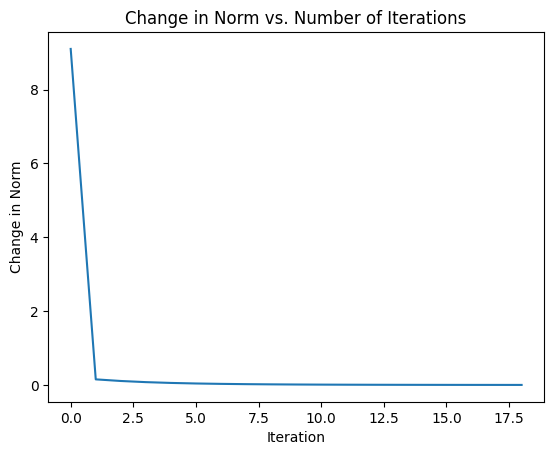

Running fuzzy_clustering with n_clusters=2 and m1=2.0  and m2=2.0
no of total iterations:  26


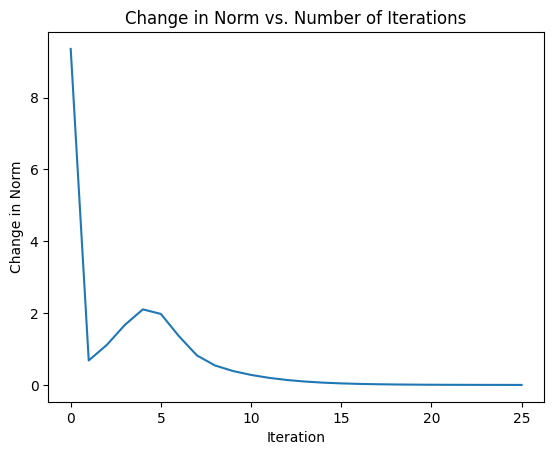

Running fuzzy_clustering with n_clusters=2 and m1=2.0  and m2=2.5
no of total iterations:  63


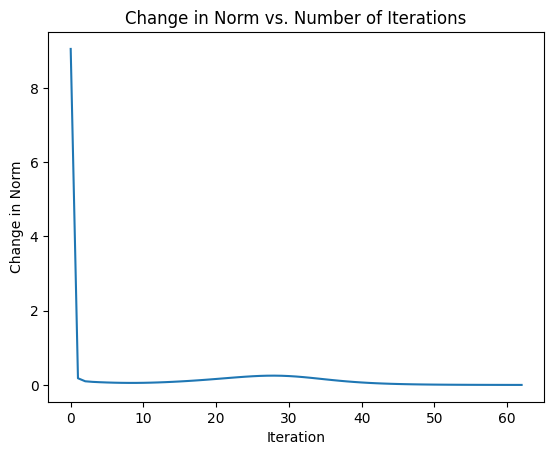

Running fuzzy_clustering with n_clusters=2 and m1=2.0  and m2=3.0
no of total iterations:  25


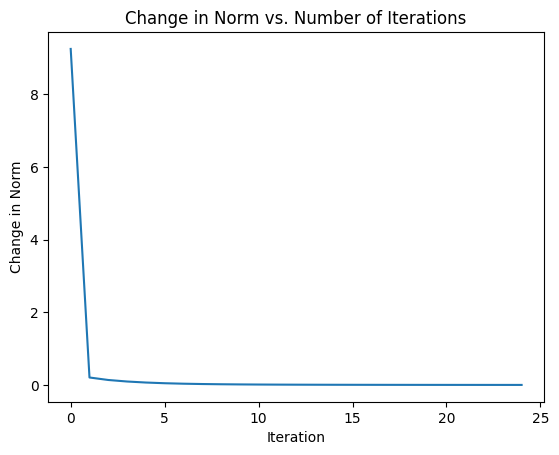

Running fuzzy_clustering with n_clusters=3 and m1=1.5  and m2=2.0
no of total iterations:  41


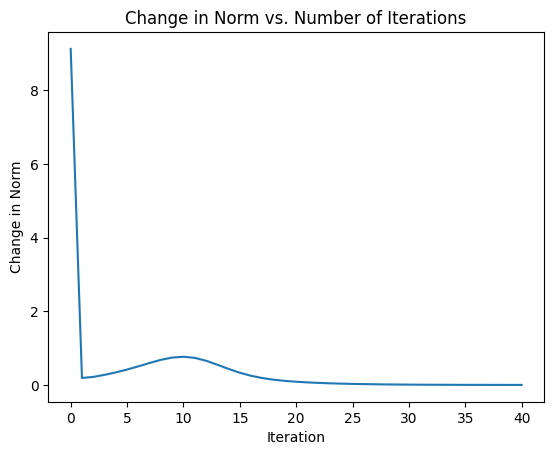

Running fuzzy_clustering with n_clusters=3 and m1=1.5  and m2=2.5
no of total iterations:  21


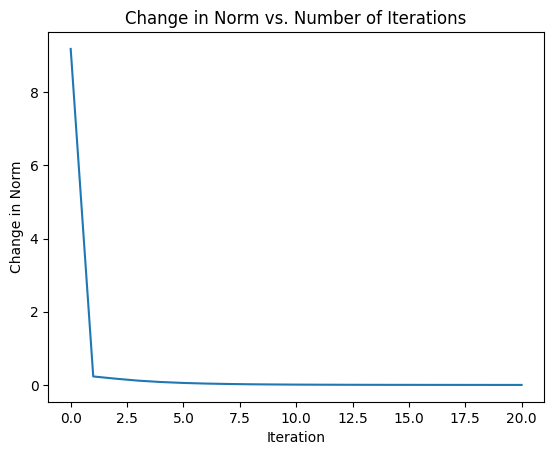

Running fuzzy_clustering with n_clusters=3 and m1=1.5  and m2=3.0
no of total iterations:  11


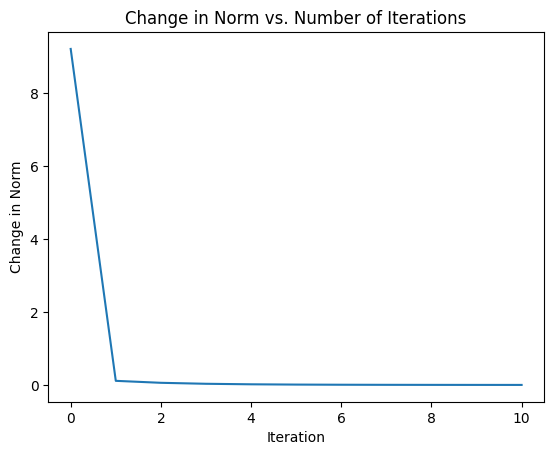

Running fuzzy_clustering with n_clusters=3 and m1=1.8  and m2=2.0
no of total iterations:  26


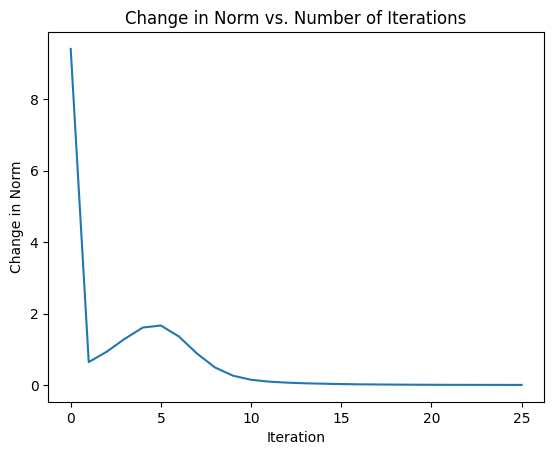

Running fuzzy_clustering with n_clusters=3 and m1=1.8  and m2=2.5
no of total iterations:  100


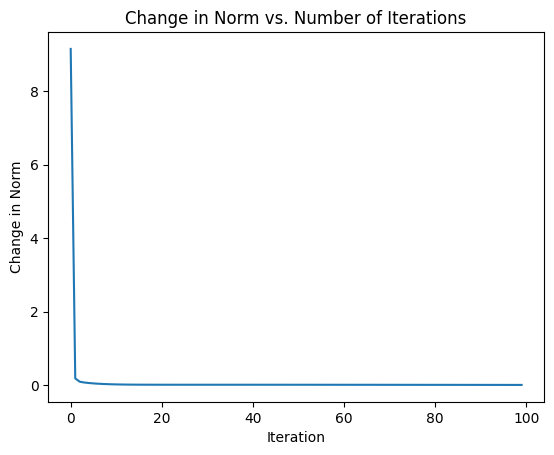

Running fuzzy_clustering with n_clusters=3 and m1=1.8  and m2=3.0
no of total iterations:  15


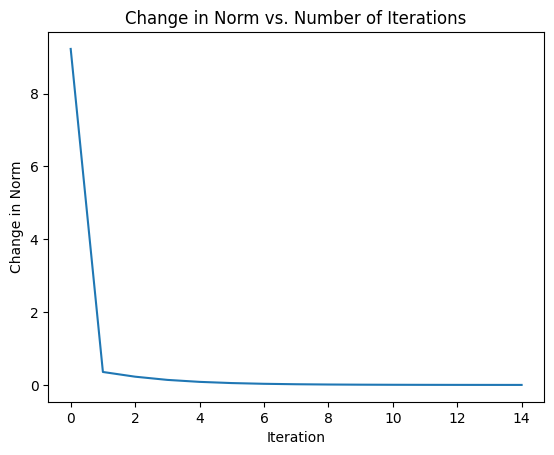

Running fuzzy_clustering with n_clusters=3 and m1=2.0  and m2=2.0
no of total iterations:  28


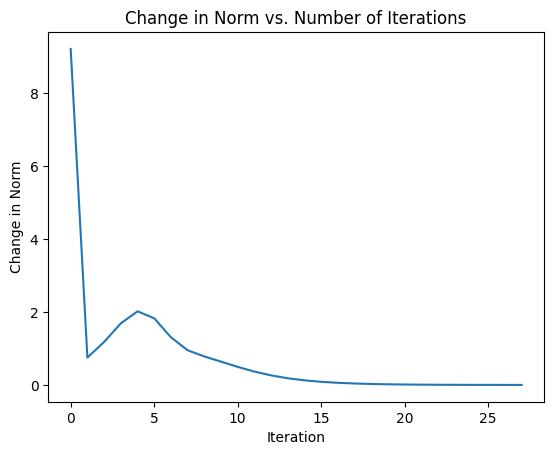

Running fuzzy_clustering with n_clusters=3 and m1=2.0  and m2=2.5
no of total iterations:  46


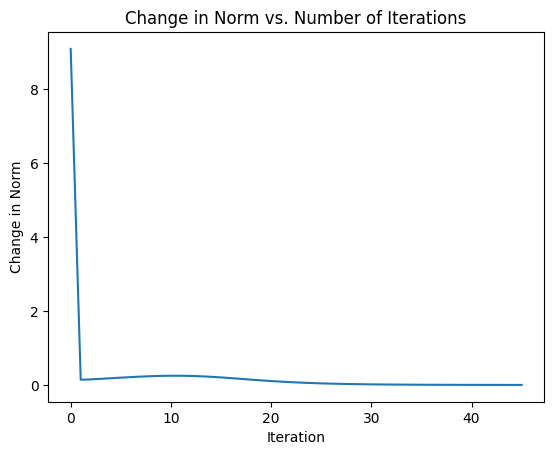

Running fuzzy_clustering with n_clusters=3 and m1=2.0  and m2=3.0
no of total iterations:  31


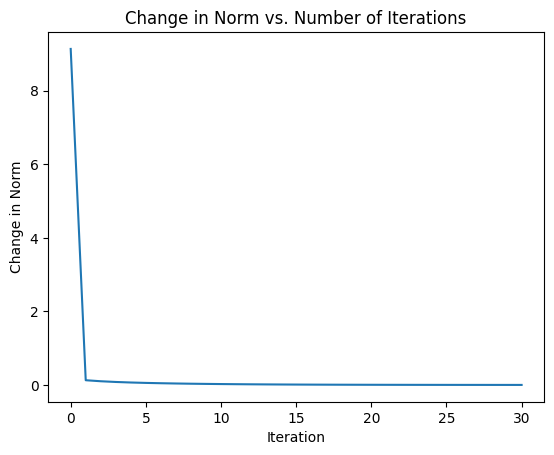

Running fuzzy_clustering with n_clusters=4 and m1=1.5  and m2=2.0
no of total iterations:  44


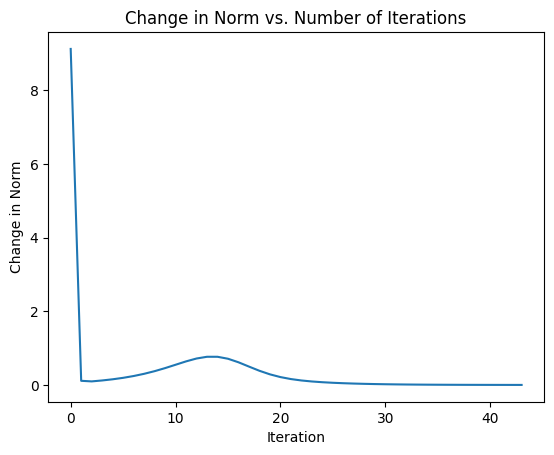

Running fuzzy_clustering with n_clusters=4 and m1=1.5  and m2=2.5
no of total iterations:  26


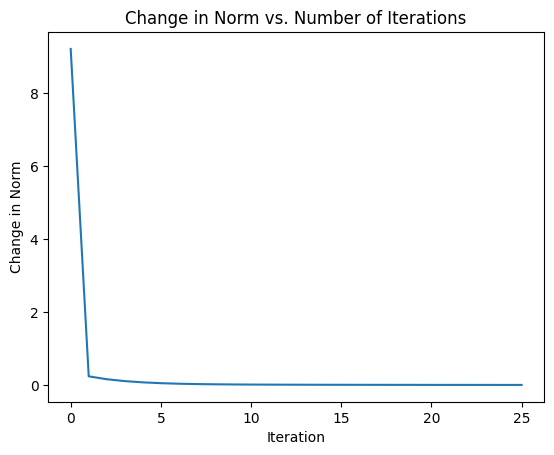

Running fuzzy_clustering with n_clusters=4 and m1=1.5  and m2=3.0
no of total iterations:  12


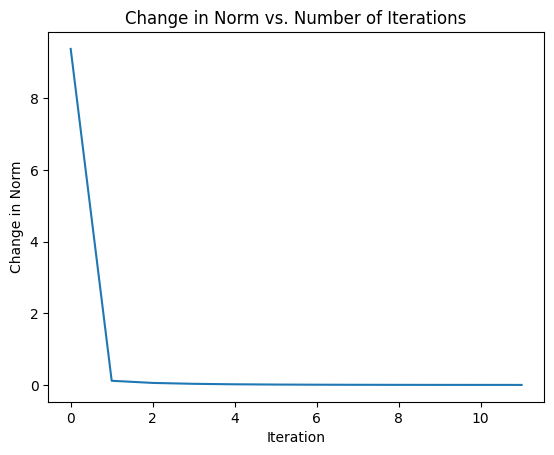

Running fuzzy_clustering with n_clusters=4 and m1=1.8  and m2=2.0
no of total iterations:  39


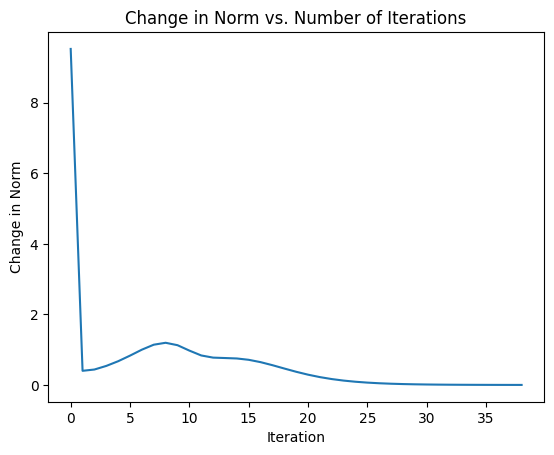

Running fuzzy_clustering with n_clusters=4 and m1=1.8  and m2=2.5
no of total iterations:  100


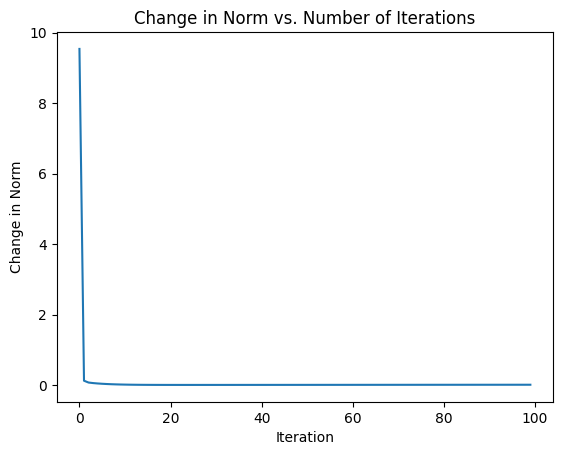

Running fuzzy_clustering with n_clusters=4 and m1=1.8  and m2=3.0
no of total iterations:  16


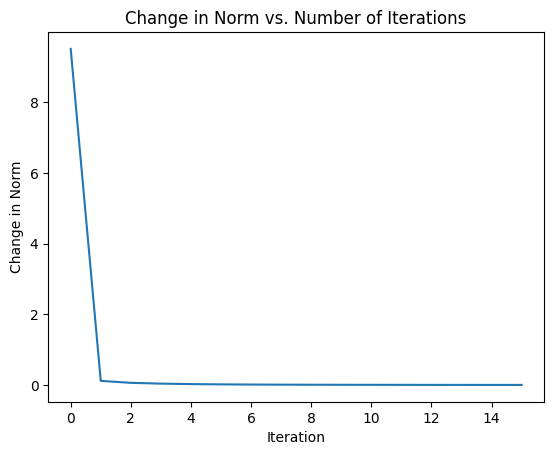

Running fuzzy_clustering with n_clusters=4 and m1=2.0  and m2=2.0
no of total iterations:  27


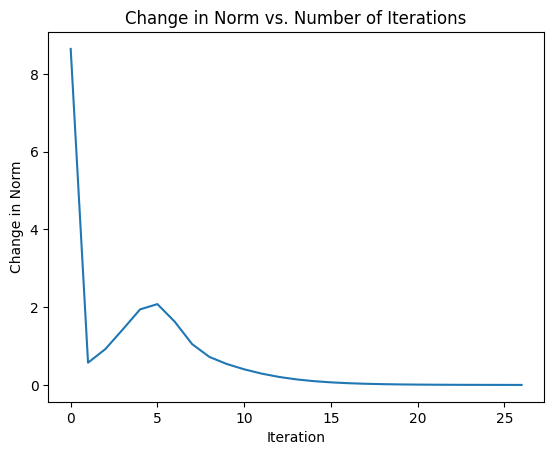

Running fuzzy_clustering with n_clusters=4 and m1=2.0  and m2=2.5
no of total iterations:  51


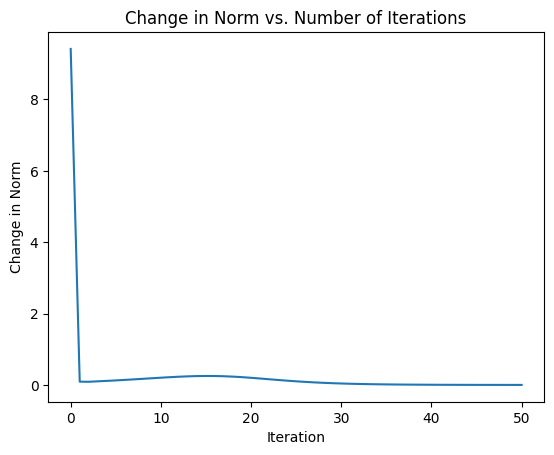

Running fuzzy_clustering with n_clusters=4 and m1=2.0  and m2=3.0
no of total iterations:  30


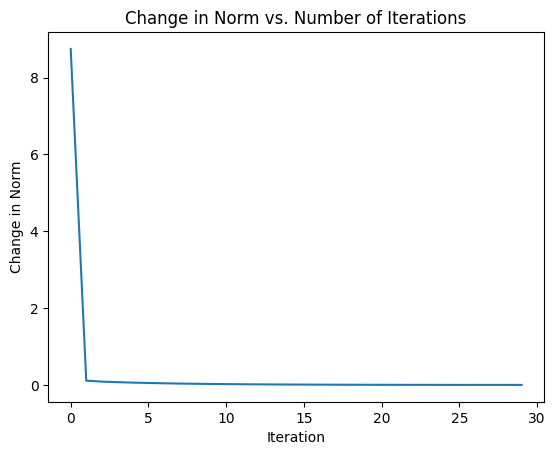

Running fuzzy_clustering with n_clusters=5 and m1=1.5  and m2=2.0
no of total iterations:  42


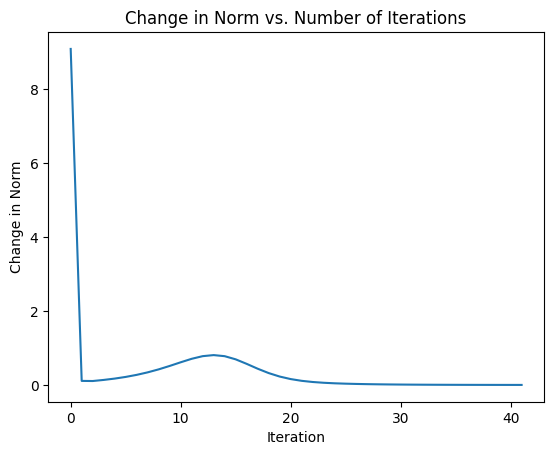

Running fuzzy_clustering with n_clusters=5 and m1=1.5  and m2=2.5
no of total iterations:  28


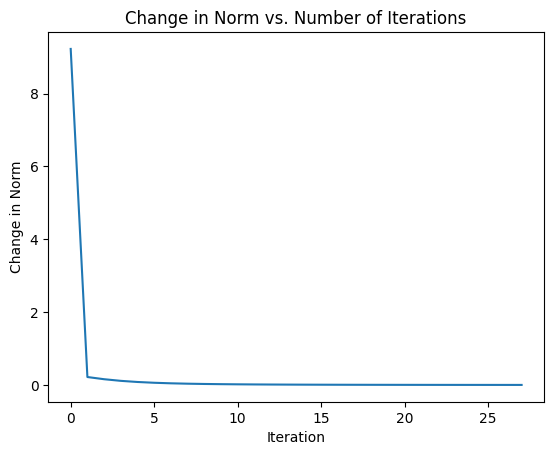

Running fuzzy_clustering with n_clusters=5 and m1=1.5  and m2=3.0
no of total iterations:  11


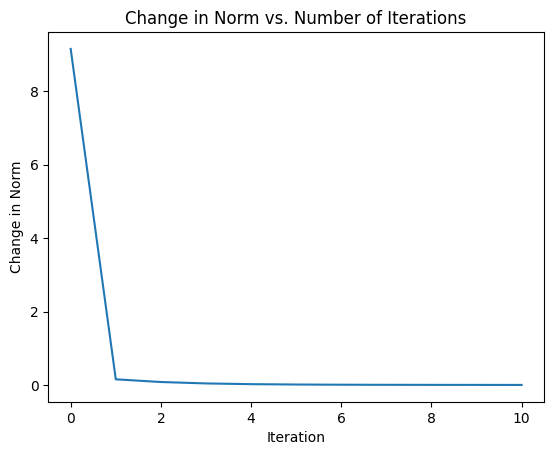

Running fuzzy_clustering with n_clusters=5 and m1=1.8  and m2=2.0
no of total iterations:  32


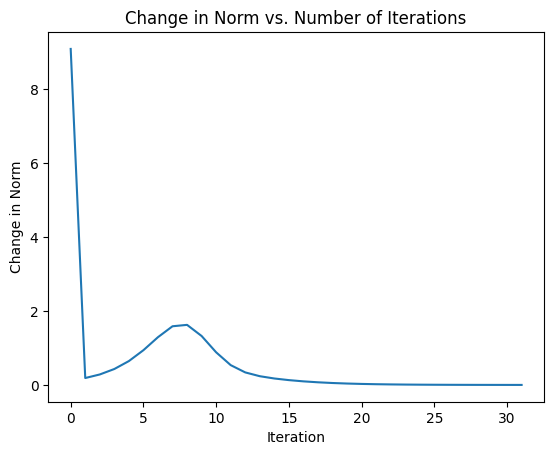

Running fuzzy_clustering with n_clusters=5 and m1=1.8  and m2=2.5
no of total iterations:  100


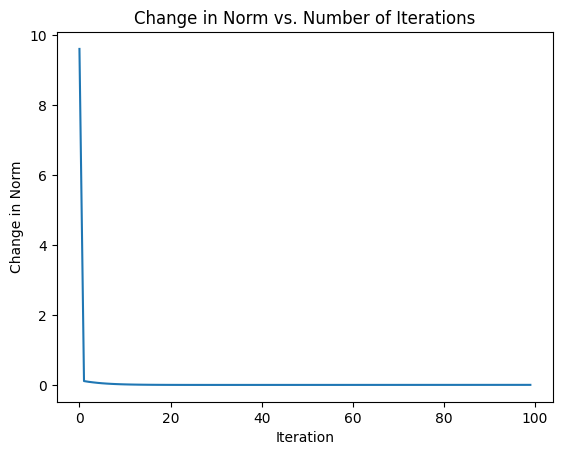

Running fuzzy_clustering with n_clusters=5 and m1=1.8  and m2=3.0
no of total iterations:  16


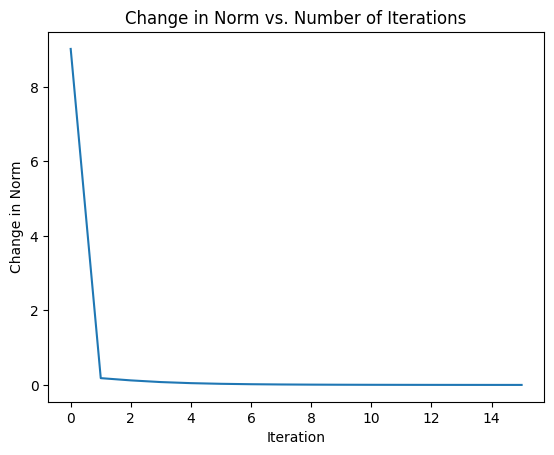

Running fuzzy_clustering with n_clusters=5 and m1=2.0  and m2=2.0
no of total iterations:  28


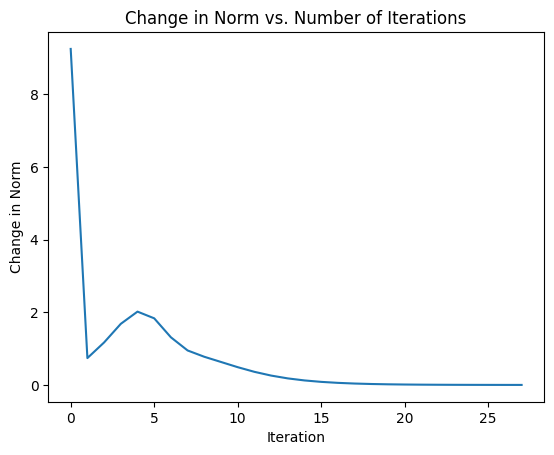

Running fuzzy_clustering with n_clusters=5 and m1=2.0  and m2=2.5
no of total iterations:  63


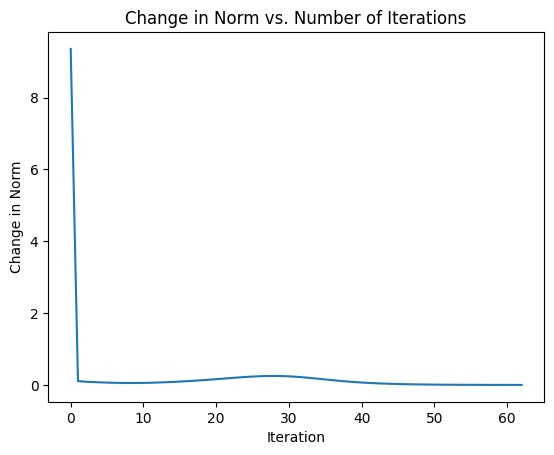

Running fuzzy_clustering with n_clusters=5 and m1=2.0  and m2=3.0
no of total iterations:  29


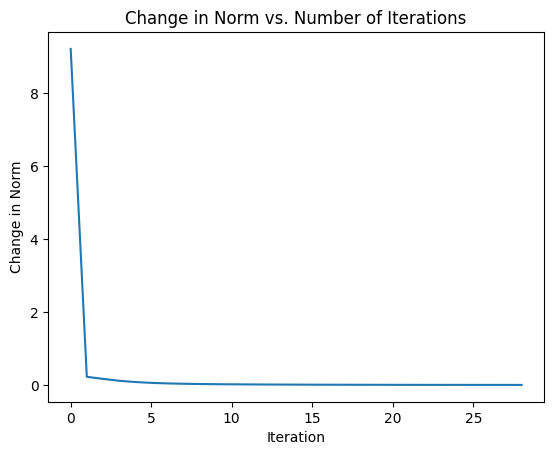

In [71]:
n_clusters_list = [2, 3, 4, 5]
m1_values = [1.5, 1.8, 2.0]
m2_values = [2.0, 2.5, 3.0]


for n_clusters in n_clusters_list:
    for m1 in m1_values:
         for m2 in m2_values:
            print(f"Running fuzzy_clustering with n_clusters={n_clusters} and m1={m1}  and m2={m2}")
            U,V =fuzzyClustering(matrix_X , m1, m2, nclusters, maxIter, tol,True)

In [73]:
def assign_crisp_labels(U):
    yfuzzy = np.argmax(U, axis=1)
    return yfuzzy

nclusters = 4
m1 = 1
m2 = 1.2
maxIter = 100
tol = 1e-3
U, V = fuzzyClustering(matrix_X , m1, m2, nclusters, maxIter, tol)
yfuzzy = assign_crisp_labels(U)
print(U)
print(yfuzzy)


[[4.35042255e-01 1.54708899e-02 3.13306930e-01 2.36179925e-01]
 [9.96862683e-01 9.98094566e-06 1.07048874e-03 2.05684714e-03]
 [9.97751998e-01 4.98181156e-10 5.17655492e-07 2.24748392e-03]
 ...
 [3.22868347e-01 1.38967486e-02 3.25311308e-01 3.37923597e-01]
 [6.97343128e-01 7.50480282e-09 7.98640060e-06 3.02648878e-01]
 [2.39745035e-03 5.86872784e-10 5.83995261e-07 9.97601965e-01]]
[0 0 0 0 1 2 0 1 3 0 1 0 0 1 0 0 0 0 3 0 3 0 3 0 0 0 1 0 3 0 0 0 1 3 0 3 0
 0 1 3 3 0 3 0 0 0 3 0 0 0 1 0 0 0 3 0 3 3 0 0 3 0 0 3 0 3 0 3 0 0 0 3 3 0
 3 0 0 0 3 0 1 3 0 0 3 0 0 3 0 3 0 3 0 0 0 3 3 0 3 0 3 0 0 0 3 1 3 0 0 0 0
 3 0 3 3 0 0 3 0 1 3 0 3 0 3 3 0 1 3 0 3 0 0 3 0 3 0 0 3 0 3 1 0 0 3 0 1 3
 0 3 0 3 3 0 0 1 0 3 0 0 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 3 1 0 0 0 0 0
 0 0 0 3 0 0 0 0 0 0 0 0 2 3 2 0 0 0 0 0 0 2 3 3 0 2 2 2 3 2 0 0 2 0 1 0 3
 2 0 0 0 2 0 3 0 2 2 0 0 2 2 2 0 2 0 2 0 3 0 2 2 0 0 2 2 2 0 2 0 2 0 3 0 2
 0 2 0 0 0 0 3 0

**Q7.** The Silhoutte score is a measure of how well the clustering has been done, the closer the score to $1.0$ the better the clustering. Refer to sklearn.metrics.silhouette_score. Determine the best choice of hyperparameters $m_1, m_2, \textrm{nclusters}$ through a grid search based on the silhoutte score as the evaluation metric. <font color='blue'>Report the best combination of hyperparameters.</font> For the grid search try $m_1 = 1.0, 1.2, \cdots, 3.0$, $m_2 = 1.2, 1.4, \cdots, 3.0$, $\textrm{nclusters} = 2, 3, \cdots, 15$.

In [85]:
def grid_search(X, max_iter=200, tol=1e-6):
    best_score = -1
    best_labels = None
    best_params = {'n_clusters': None, 'm1': None, 'm2': None}
    
    m1_range = [round(1.0 + i * 0.2, 1) for i in range(int((3.0 - 1.0) / 0.2) + 1)]
    m2_range = [round(1.2 + i * 0.2, 1) for i in range(int((3.0 - 1.2) / 0.2) + 1)]
    
    for nclusters in range(2,16):
        for m1 in m1_range:
            for m2 in m2_range:
                U, V= fuzzyClustering(X , m1, m2, nclusters, maxIter, tol)
                labels = assign_crisp_labels(U)
                score = silhouette_score(X, labels)
                print(f"n_clusters: {nclusters}, m1: {m1}, m2: {m2}, Silhouette Score: {score}")
                if score > best_score:
                    best_score = score
                    best_params['n_clusters'] = nclusters
                    best_params['m1'] = m1
                    best_params['m2'] = m2
                    best_labels = labels
                
    return best_params, best_score, best_labels

print(matrix_X ,matrix_X.shape)
best_params,best_score, best_labels= grid_search(matrix_X)
print(best_labels)
print(best_params,best_score)

[[0.28571429 0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.42857143 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.45714286 0.         1.         ... 0.         0.         0.        ]
 [0.47142857 0.         0.         ... 0.         0.         0.        ]
 [0.52857143 0.         0.         ... 0.         0.         0.        ]] (732, 11)
n_clusters: 2, m1: 1.0, m2: 1.2, Silhouette Score: 0.2507022700527657
n_clusters: 2, m1: 1.0, m2: 1.4, Silhouette Score: 0.24927836775251216
n_clusters: 2, m1: 1.0, m2: 1.6, Silhouette Score: 0.2511689013439909
n_clusters: 2, m1: 1.0, m2: 1.8, Silhouette Score: 0.25312225293070373


n_clusters: 2, m1: 1.0, m2: 2.0, Silhouette Score: 0.2533797353220362
n_clusters: 2, m1: 1.0, m2: 2.2, Silhouette Score: 0.2533797353220362
n_clusters: 2, m1: 1.0, m2: 2.4, Silhouette Score: 0.253183289582901
n_clusters: 2, m1: 1.0, m2: 2.6, Silhouette Score: 0.253183289582901
n_clusters: 2, m1: 1.0, m2: 2.8, Silhouette Score: 0.4019817042355911
n_clusters: 2, m1: 1.0, m2: 3.0, Silhouette Score: 0.2533797353220362
n_clusters: 2, m1: 1.2, m2: 1.2, Silhouette Score: 0.24918798945745574
n_clusters: 2, m1: 1.2, m2: 1.4, Silhouette Score: 0.2451393565275503
n_clusters: 2, m1: 1.2, m2: 1.6, Silhouette Score: 0.24927836775251216
n_clusters: 2, m1: 1.2, m2: 1.8, Silhouette Score: 0.25086188873648163
n_clusters: 2, m1: 1.2, m2: 2.0, Silhouette Score: 0.2533797353220362
n_clusters: 2, m1: 1.2, m2: 2.2, Silhouette Score: 0.2533797353220362
n_clusters: 2, m1: 1.2, m2: 2.4, Silhouette Score: 0.2533797353220362
n_clusters: 2, m1: 1.2, m2: 2.6, Silhouette Score: 0.2533797353220362
n_clusters: 2, m1: 

**Q8.** For the best combination of hyperparameters run the following visualization function with different values for $0 \leq f_1 < f_2 < \textrm{nclusters}$. <font color='blue'>What do you see? Explain the purpose of the code and what you would expect through this?</font>

In [82]:
def visualizeClusters2D(X, y, f1, f2):
    colorlist = ['black', 'gray', 'red', 'sienna', 'green', 'blue', 'gold', 'darkorange', 'olive',  'salmon', 'teal', 'pink', 'magenta', 'tan', 'wheat']
   
    for i in range(4):
        plt.scatter(X[yfuzzy == i, f1], X[yfuzzy == i, f2], color = colorlist[i])

    plt.show()


plot for f1 =  0  and f2   1


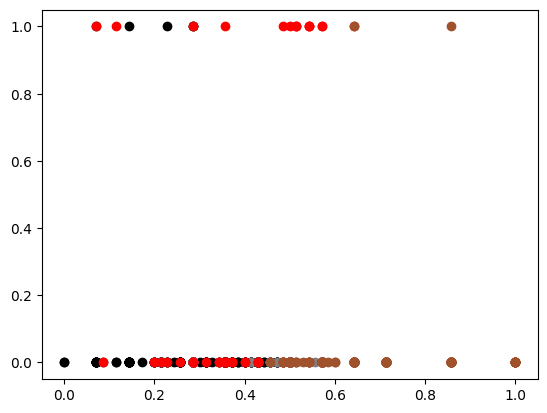

In [84]:
nclusters = 2
for f1 in range(0,nclusters):
    for f2 in range(0,nclusters):
        if(f2 > f1):
            print( "plot for f1 = ",f1, " and f2  ", f2)
            visualizeClusters2D(matrix_X , best_labels ,f1, f2)

**Q9.** Load (to a pandas dataframe) the actual dataset (SMData.csv) from which the previous dataset was cleaned out. Match each entry in this dataset with the labels you found out through clustering using the best combination of hyperparameters. Go through a few of those clustered entries and notice any patterns (or common sentiment) in the text (the "Text" column of this dataset) of each entry within clusters vs outside the clusters. The label of the $i$th entry in the dataset $= \textrm{yfuzzy}[i]$. <font color='blue'>Explain any observations. Based on your observations, is the clustering successful?</font>

In [59]:
dataframe2 = pd.read_csv('SMData.csv')

dataframe2['Cluster_Label'] = best_yfuzzy

for index, row in dataframe2.iterrows():
    print(f"Row {index}:")
    print(row)
    print(f"Cluster Label: {row['Cluster_Label']}")
    print("-" * 50)
    if index == 30:
        break


Row 0:
Unnamed: 0.1                                                     0
Unnamed: 0                                                       0
Text              Enjoying a beautiful day at the park!        ...
Sentiment                                               Positive  
Timestamp                                      2023-01-15 12:30:00
User                                                 User123      
Platform                                                 Twitter  
Hashtags                 #Nature #Park                            
Retweets                                                      15.0
Likes                                                         30.0
Country                                                  USA      
Year                                                          2023
Month                                                            1
Day                                                             15
Hour                                                   